## Data Description

|    Variable            	|    Definition                         |     
|---------------------------|---------------------------------------|
|    employee_id         	|    Unique ID for employee             |     
|    department          	|    Department of employee             |     
|    region              	|    Region of employment (unordered)   |     
|    education           	|    Education Level                    |     
|    gender              	|    Gender of Employee                 |     
|    recruitment_channel 	|    Channel of recruitment for employee |    
|    no_of_trainings     	|    no of other trainings completed in previous year on soft skills, technical skills etc. |
|    age                 	|    Age of Employee                         |
|    previous_year_rating	|    Employee Rating for the previous year   |
|    length_of_service   	|    Length of service in years              
|    KPIs_met >80%       	|    if Percent of KPIs(Key performance Indicators) >80% then 1 else 0 |
|    awards_won?         	|    if awards won during previous year then 1 else 0 |
|    avg_training_score  	|    Average score in current training evaluations |
|    is_promoted         	|    (Target) Recommended for promotion      |


## EVALUATION METRIC

The evaluation metric for this competition is F1 Score.


## Importing Python Modules

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union

In [136]:
sns.set_style('whitegrid')
# sns.set(context="paper", font="monospace")

## Data Loading 

In [137]:
def load_training_dataset():
    return pd.read_csv('data/train_LZdllcl.csv', index_col='employee_id')
df = load_training_dataset()
df = df.rename(columns={'KPIs_met >80%':'is_kpi_met', 'awards_won?':'has_won_awards'})
print('Train Data Size :', df.shape)
df.head()

Train Data Size : (54808, 13)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [138]:
test = pd.read_csv('data/test_2umaH9m.csv', index_col='employee_id')
test = test.rename(columns={'KPIs_met >80%':'is_kpi_met', 'awards_won?':'has_won_awards'})
print('Test Data Size :', test.shape)
test.head()

Test Data Size : (23490, 12)


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score
employee_id,,,,,,,,,,,,
8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [139]:
test.isnull().sum()

department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
is_kpi_met                 0
has_won_awards             0
avg_training_score         0
dtype: int64

## Data Pre-processing 

In [140]:
df.isnull().sum()

department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
is_kpi_met                 0
has_won_awards             0
avg_training_score         0
is_promoted                0
dtype: int64

In [141]:
# Is there anyone who is promoted whose education is null??
mask = (df.education.isnull() == True) & (df.is_promoted == 1)
print('Is there anyone who is promoted whose education is null?? : ', df[mask].shape[0], 'folks!')
df[mask].describe().T

Is there anyone who is promoted whose education is null?? :  122 folks!


,count,mean,std,min,25%,50%,75%,max
no_of_trainings,122.0,1.114754,0.533145,1.0,1.0,1.0,1.0,6.0
age,122.0,29.172131,6.729352,20.0,24.0,28.0,32.0,60.0
previous_year_rating,97.0,4.061856,1.028899,1.0,3.0,4.0,5.0,5.0
length_of_service,122.0,3.950820,3.177536,1.0,2.0,3.0,5.0,16.0
is_kpi_met,122.0,0.704918,0.457960,0.0,0.0,1.0,1.0,1.0
has_won_awards,122.0,0.163934,0.371743,0.0,0.0,0.0,0.0,1.0
avg_training_score,122.0,68.008197,17.208731,45.0,50.0,64.0,85.0,98.0
is_promoted,122.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [142]:
df[df.previous_year_rating.isnull() == True].head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,is_kpi_met,has_won_awards,avg_training_score,is_promoted
employee_id,,,,,,,,,,,,,
29934,Technology,region_23,NaN,m,sourcing,1,30,NaN,1,0,0,77,0
71177,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,0,70,0
74759,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,0,44,0
45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,0,49,0
26599,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,1,0,47,0


In [143]:
# Is there anyone who is promoted whose previous_year_rating is null??
mask = (df.previous_year_rating.isnull() == True) & (df.is_promoted == 1)
print('Is there anyone who is promoted whose previous_year_rating is null?? : ', df[mask].shape[0], 'folks!')
# df[mask].head()

Is there anyone who is promoted whose previous_year_rating is null?? :  339 folks!


In [144]:
# Is there anyone whose length_of_service>1  with previous_year_rating as null??
mask = (df.previous_year_rating.isnull() == True) & (df.length_of_service > 1)
print('Is there anyone whose length_of_service>1  with previous_year_rating as null?? : ', df[mask].shape[0], 'folks!')
# df[mask].head()
# Observation
# If only length_of_service=1, the previous_year_rating = NaN
# Possibility of FeatureEngineering?? length_of_service*previous_year_rating, setting NaN=0 
# [Could be wrong bcoz only last rating is available. What if last ratig is bad but exp is more?]
# How does this look for test dataset?

Is there anyone whose length_of_service>1  with previous_year_rating as null?? :  0 folks!


In [145]:
# How does this look for test dataset?
# Is there anyone whose length_of_service>1  with previous_year_rating as null??
mask = (test.previous_year_rating.isnull() == True) & (test.length_of_service > 1)
print('Is there anyone whose length_of_service>1  with previous_year_rating as null in TEST DATASET?? : ', test[mask].shape[0], 'folks!')
# None, so we can set the value as Zero

Is there anyone whose length_of_service>1  with previous_year_rating as null in TEST DATASET?? :  0 folks!


In [146]:
print(df.info())

df['is_promoted'] = df['is_promoted'].astype(np.int8)
df['avg_training_score'] = df['avg_training_score'].astype(np.int8)
df['has_won_awards'] = df['has_won_awards'].astype(np.int8)
df['is_kpi_met'] = df['is_kpi_met'].astype(np.int8)
df['length_of_service'] = df['length_of_service'].astype(np.int8)
df['age'] = df['age'].astype(np.int8)
df['no_of_trainings'] = df['no_of_trainings'].astype(np.int8)

df['previous_year_rating'] = df['previous_year_rating'].astype(np.float16)

df['department'] = df['department'].astype('category')
df['region'] = df['region'].astype('category')
df['education'] = df['education'].astype('category')
df['gender'] = df['gender'].astype('category')
df['recruitment_channel'] = df['recruitment_channel'].astype('category')

print('\nAfter processing:\n',)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
department              54808 non-null object
region                  54808 non-null object
education               52399 non-null object
gender                  54808 non-null object
recruitment_channel     54808 non-null object
no_of_trainings         54808 non-null int64
age                     54808 non-null int64
previous_year_rating    50684 non-null float64
length_of_service       54808 non-null int64
is_kpi_met              54808 non-null int64
has_won_awards          54808 non-null int64
avg_training_score      54808 non-null int64
is_promoted             54808 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 5.9+ MB
None

After processing:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54808 entries, 65438 to 51526
Data columns (total 13 columns):
department              54808 non-null category
region                  54808 non-null category

In [147]:
print(test.info())

# test['is_promoted'] = test['is_promoted'].astype(np.int8)
test['avg_training_score'] = test['avg_training_score'].astype(np.int8)
test['has_won_awards'] = test['has_won_awards'].astype(np.int8)
test['is_kpi_met'] = test['is_kpi_met'].astype(np.int8)
test['length_of_service'] = test['length_of_service'].astype(np.int8)
test['age'] = test['age'].astype(np.int8)
test['no_of_trainings'] = test['no_of_trainings'].astype(np.int8)

test['previous_year_rating'] = test['previous_year_rating'].astype(np.float16)

test['department'] = test['department'].astype('category')
test['region'] = test['region'].astype('category')
test['education'] = test['education'].astype('category')
test['gender'] = test['gender'].astype('category')
test['recruitment_channel'] = test['recruitment_channel'].astype('category')

print('\nAfter processing:\n',)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 8724 to 5973
Data columns (total 12 columns):
department              23490 non-null object
region                  23490 non-null object
education               22456 non-null object
gender                  23490 non-null object
recruitment_channel     23490 non-null object
no_of_trainings         23490 non-null int64
age                     23490 non-null int64
previous_year_rating    21678 non-null float64
length_of_service       23490 non-null int64
is_kpi_met              23490 non-null int64
has_won_awards          23490 non-null int64
avg_training_score      23490 non-null int64
dtypes: float64(1), int64(6), object(5)
memory usage: 2.3+ MB
None

After processing:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23490 entries, 8724 to 5973
Data columns (total 12 columns):
department              23490 non-null category
region                  23490 non-null category
education               22456 non-null category


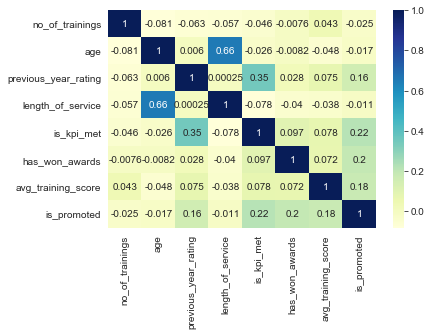

In [148]:
# Compute the correlation matrix
correlations = df.corr()
correlations
# Obsrvation: 
# Age and Length of service has a good correlation of 0.657111. 
# But then both these features - age and length_of_service don't seem to have any correlation with the target - is_promoted.
# no_of_trainings as well has poor correlation with target - is_promoted column.

# plot correlation matrix
sns.heatmap(correlations,cmap="YlGnBu",annot=True)

In [149]:
def correlaton_summary(correlations):
    correlation_df = pd.DataFrame(correlations['is_promoted'])
    correlation_df.columns = ["Correlation"]
    correlation_df = correlation_df.sort_values(by=['Correlation'], ascending=False)
    return correlation_df

correlaton_summary(correlations)

,Correlation
is_promoted,1.000000
is_kpi_met,0.221582
has_won_awards,0.195871
avg_training_score,0.181147
previous_year_rating,0.159320
length_of_service,-0.010670
age,-0.017166
no_of_trainings,-0.024896


In [150]:
# def score(df):
#     df['score'] = (7.5 * df['is_kpi_met']) + (5.5 * df['has_won_awards']) + (1.5 * df['previous_year_rating']) + (.25 * df['avg_training_score'])
#     return df

# df.fillna({'previous_year_rating':3}, inplace=True)
# correlaton_summary( score(df).corr() )

In [151]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.0,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.0,33.0,39.0,60.0
previous_year_rating,50684.0,inf,1.259766,1.0,3.0,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.0,5.0,7.0,37.0
is_kpi_met,54808.0,0.351974,0.477590,0.0,0.0,0.0,1.0,1.0
has_won_awards,54808.0,0.023172,0.150450,0.0,0.0,0.0,0.0,1.0
avg_training_score,54808.0,63.386750,13.371559,39.0,51.0,60.0,76.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.0,0.0,0.0,1.0


In [152]:
# test.fillna({'previous_year_rating':3}, inplace=True)
# score(test).corr()

## Data Modeling

In [153]:
class RatingsImputer(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        #X.loc[X.previous_year_rating.isnull(), 'previous_year_rating'] = 0
        X = X.fillna({'previous_year_rating':3})
        return X

# fillna_pipe.fit_transform(df).isnull().sum() # For Testing purpose only

In [154]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit (self, X, y=None, **fit_params):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using LabelEncoder(). 
        If no columns specified, transforms all columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [155]:
select_columns = ['is_kpi_met', 'has_won_awards', 'avg_training_score', 'previous_year_rating'] # Removing 'education'
select_numeric_cols = ['avg_training_score', 'has_won_awards', 'is_kpi_met', 'previous_year_rating']
# select_categorical_cols = ['education']
select_categorical_cols = []

# fillna_pipe = make_pipeline(RatingsImputer(), EducationCleanser())
fillna_pipe = make_pipeline(RatingsImputer())
select_categorical_cols_pipe = make_pipeline(ColumnSelector(columns=select_categorical_cols), MultiColumnLabelEncoder())
select_numeric_cols_pipe = make_pipeline(ColumnSelector(columns=select_numeric_cols),RobustScaler())

select_fu = make_union(select_numeric_cols_pipe, select_categorical_cols_pipe)
select_pipe = make_pipeline(fillna_pipe, select_fu)

# Do FIT_TRANSFORM again based on selected columns after correlation
train_vec = select_pipe.fit_transform(df[select_columns])
print(train_vec.shape)
print(train_vec[:3])

(54808, 4)
[[-0.44  0.    1.    2.  ]
 [ 0.    0.    0.    2.  ]
 [-0.4   0.    0.    0.  ]]


In [156]:
# Split train data-set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_vec, 
                                                    df['is_promoted'], 
                                                    train_size = 0.75, 
                                                    random_state = 42)

In [157]:
test_vec = select_pipe.transform(test[select_columns])
test_vec[:5]

array([[ 0.68,  0.  ,  1.  ,  0.  ],
       [-0.36,  0.  ,  0.  ,  0.  ],
       [-0.52,  0.  ,  0.  , -2.  ],
       [ 0.2 ,  0.  ,  0.  , -1.  ],
       [ 0.04,  0.  ,  0.  ,  1.  ]])

## LGBoost for Classification

0    14004
1     4668
Name: is_promoted, dtype: int64


Text(0,0.5,'Frequency')

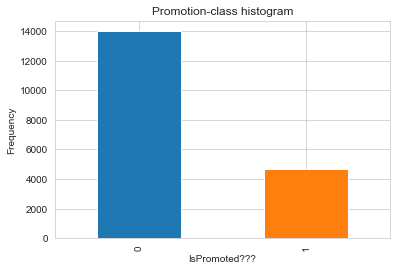

In [211]:
# Ref.: https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now
dframe = pd.DataFrame(data=train_vec, columns=select_columns)
dframe['is_promoted'] = df['is_promoted'].values

# Number of data points in the minority class
promoted_ones = dframe[dframe.is_promoted==1]
others = dframe[dframe.is_promoted==0]
others_sample = others.sample(promoted_ones.shape[0] * 3) # N-times the size of promoted_ones

newdf = pd.concat([promoted_ones, others_sample])
newdf = newdf.sample(frac=1)

count_classes = pd.value_counts(newdf['is_promoted'], sort = True).sort_index()
print(count_classes)
count_classes.plot(kind = 'bar')
plt.title("Promotion-class histogram")
plt.xlabel("IsPromoted???")
plt.ylabel("Frequency")

In [212]:
newdf.head()

,is_kpi_met,has_won_awards,avg_training_score,previous_year_rating,is_promoted
6290,-0.08,0.0,0.0,0.0,0
7627,-0.04,0.0,1.0,0.0,1
6418,-0.44,0.0,0.0,1.0,0
39518,0.28,0.0,0.0,0.0,1
50282,1.04,0.0,0.0,1.0,0


In [213]:
x = newdf[['is_kpi_met', 'has_won_awards', 'avg_training_score', 'previous_year_rating']]
y = newdf['is_promoted']
x_train, x_test, y_train, y_test = train_test_split(x, y,  
                                                    train_size = 0.75, 
                                                    random_state = 42)

In [250]:
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score, cross_validate

lgb_clf=LGBMClassifier(random_state=42, silent=False, learning_rate=.15, n_estimators=100, class_weight={0:1, 1:5})

scores = cross_val_score(lgb_clf, x_train, y_train, cv=3, scoring='f1')
scores # Check against the recall score, for this is something the  Public LeaderBoard is scoring against.

array([0.5885273 , 0.5890411 , 0.58333333])

In [251]:
from sklearn.metrics import classification_report, confusion_matrix

lgb_clf.fit(x_train, y_train)
preds = lgb_clf.predict(x)

print('Accuracy = ', np.mean(preds == y))

creport = classification_report(y, preds, target_names=['Not Promoted', 'Promoted'])
print(creport)

confusion_matrix(y, preds)

Accuracy =  0.6780741216795202
              precision    recall  f1-score   support

Not Promoted       0.96      0.60      0.74     14004
    Promoted       0.43      0.92      0.59      4668

 avg / total       0.83      0.68      0.70     18672



array([[8372, 5632],
       [ 379, 4289]], dtype=int64)

In [209]:
def conv2df(preds):
    df = pd.DataFrame(data={
        'employee_id': test.index.values,
        'is_promoted': preds
    })
    df['is_promoted'] = df['is_promoted'].astype(np.int8)
    return df

In [210]:
conv2df(lgb_clf.predict(test_vec)).to_csv('data/output/LGB_sd.csv', index=False)

In [231]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

xgb_clf=XGBClassifier(random_state=42, silent=False, n_jobs=-1, learning_rate=.3, n_estimators=45)

scores = cross_val_score(xgb_clf, x_train, y_train, cv=3, scoring='f1')
print('Scores:', scores) 
# [0.24233577 0.28235294 0.26912181] with learning_rate=.5, n_estimators=100

xgb_clf.fit(x_train, y_train)
preds = xgb_clf.predict(x)

print('Accuracy = ', np.mean(preds == y))

creport = classification_report(y, preds, target_names=['Not Promoted', 'Promoted'])
print(creport)

confusion_matrix(y, preds)

Scores: [0.44535359 0.4403778  0.42173656]
Accuracy =  0.7997000856898029
              precision    recall  f1-score   support

Not Promoted       0.81      0.96      0.88     14004
    Promoted       0.73      0.31      0.44      4668

 avg / total       0.79      0.80      0.77     18672



array([[13474,   530],
       [ 3210,  1458]], dtype=int64)

In [ ]:
conv2df(xgb_clf.predict(test_vec)).to_csv('data/output/XGB_sd.csv', index=False)

In [259]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

# Ref.: https://stackoverflow.com/questions/37413302/f1-score-of-all-classes-from-scikits-cross-val-score
# Ref.: https://stackoverflow.com/questions/35876508/evaluate-multiple-scores-on-sklearn-cross-val-score
# svc_clf = SVC(random_state=42, kernel='rbf', degree=5, decision_function_shape='ovo', gamma=175, C=25.5)
 
# Ref.: http://bigdata-madesimple.com/dealing-with-unbalanced-class-svm-random-forest-and-decision-tree-in-python/
# svc_clf = SVC(random_state=42, kernel='rbf', degree=5, decision_function_shape='ovo', gamma=175, C=25.5, class_weight='balanced')
svc_clf = SVC(random_state=42, kernel='rbf', degree=3, class_weight='balanced', C=20)

scores = cross_val_score(svc_clf, x_train, y_train, cv=3, scoring='f1')
print('Scores : ', scores)
# [0.59459459 0.59515366 0.59976387] with degree=5, class_weight='balanced'

svc_clf.fit(x_train, y_train)
preds = svc_clf.predict(x)

print('Accuracy = ', np.mean(preds == y))

creport = classification_report(y, preds, target_names=['Not Promoted', 'Promoted'])
print(creport)

confusion_matrix(y, preds)

Scores :  [0.5989908  0.60158777 0.60454143]
Accuracy =  0.7129927163667523
              precision    recall  f1-score   support

Not Promoted       0.93      0.66      0.78     14004
    Promoted       0.46      0.86      0.60      4668

 avg / total       0.82      0.71      0.73     18672



array([[9308, 4696],
       [ 663, 4005]], dtype=int64)

In [260]:
conv2df(svc_clf.predict(test_vec)).to_csv('data/output/svc_sd.csv', index=False)